# [GD-04] 프로젝트: 한영 번역기 만들기

In [16]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

print("완료!")

완료!


## Step 1. 데이터 다운로드

### 데이터 준비하기

In [17]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

print(tf.__version__)

2.6.0


In [36]:
file_path = os.getenv('HOME')+'/aiffel/s2s_translation'
print(file_path)

/aiffel/aiffel/s2s_translation


In [37]:
def load_file(file_name):
    with open(file_path+'/{}'.format(file_name), "r") as f:
        raw = f.read().splitlines()

    print("Data Size:", len(raw))
    print("Example:")

    for sen in raw[0:100][::20]: 
        print(">>", sen)
    
    return raw

In [41]:
raw_ko = load_file('korean-english-park.train.ko')
raw_en = load_file('korean-english-park.train.en')

print('total korean data size:', len(raw_ko))
print('total english data size:', len(raw_en))

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.
Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give th

## Step 2. 데이터 정제

1. set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거하도록 합니다. 데이터의 병렬 쌍이 흐트러지지 않게 주의하세요! 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.
2. 앞서 정의한 preprocessing() 함수는 한글에서는 동작하지 않습니다. 한글에 적용할 수 있는 정규식을 추가하여 함수를 재정의하세요!  
3. 타겟 언어인 영문엔 <start> 토큰과 <end> 토큰을 추가하고 split() 함수를 이용하여 토큰화합니다. 한글 토큰화는 KoNLPy의 mecab 클래스를 사용합니다.



In [42]:
raw = zip(raw_ko, raw_en)
raw

cf) chatGTP  
It seems like you're trying to process a dataset by unzipping and then re-zipping it using the zip function in Python.   
I'll explain what it seems to be doing:  
set_raw is probably a list of tuples, where each tuple contains a pair of sentences - one in Korean ("cleaned_corpus_kor") and one in English ("cleaned_corpus_eng").
zip(*set_raw) is being used to unzip this list of tuples into two separate lists: one containing all the Korean sentences and one containing all the English sentences.


In [43]:
set_raw = set(raw)

In [45]:
len(set_raw)

78968

In [46]:
cleaned_corpus_kor, cleaned_corpus_eng = zip(*set_raw)

In [53]:
for kor, eng in zip(cleaned_corpus_kor, cleaned_corpus_eng):
    print(f"Korean: {kor}, English: {eng}")
    break

Korean: 미시건 출신인 펠프스는 “오늘밤 내 세계 기록을 2초나 앞당길줄 몰랐다”고 소감을 밝혔다., English: "I didn't expect to be two seconds under my world record tonight," said the 21-year-old from Michigan.


In [49]:
cleaned_corpus_kor[300]

'이 잔혹한 발견으로 이번 사건에서 사망한 것으로 확인된 사람의 수는 11명으로 증가하였다.'

In [50]:
cleaned_corpus_eng[300]

'The grim discoveries bring to eleven the number of people known dead in the accident.'

In [51]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.,!가-힣ㄱ-ㅎㅏ-ㅣ]+", " ", sentence)     #한글에 적용할 수 있는 정규식

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

print("슝~")

슝~


In [54]:
enc_corpus = []
dec_corpus = []


for kor, eng in zip(cleaned_corpus_kor, cleaned_corpus_eng):
    temp_kor = preprocess_sentence(kor)
    temp_eng = preprocess_sentence(eng, s_token=True, e_token=True)

    if len(temp_kor) <= 40:
        enc_corpus.append(preprocess_sentence(kor))
        dec_corpus.append(preprocess_sentence(eng, s_token=True, e_token=True))

print('korean data size:', len(enc_corpus))
print('english data size:', len(dec_corpus))
print("Korean:", enc_corpus[500])   
print("English:", dec_corpus[500])  

korean data size: 16261
english data size: 16261
Korean: 외교부는 성명을 통해 동결된 자금 문제가 마침내 해결되었다 고 밝혔다 .
English: <start> the issue of the frozen funds has finally been settled . <end>


## Step 3. 데이터 토큰화
앞서 정의한 tokenize() 함수를 사용해 데이터를 텐서로 변환하고 각각의 tokenizer를 얻으세요! 단어의 수는 실험을 통해 적당한 값을 맞춰주도록 합니다! (최소 10,000 이상!)

❗ 주의: 난이도에 비해 데이터가 많지 않아 훈련 데이터와 검증 데이터를 따로 나누지는 않습니다.

In [88]:
# 어려웠던 부분!
from konlpy.tag import Mecab

vocab_size = 50000
def tokenize(corpus, kor=False, eng=True):
    if kor:
        mecab = Mecab()
        morph = [" ".join(mecab.morphs(sen)) for sen in corpus]
        tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',
                                                         num_words=vocab_size)
        tokenizer.fit_on_texts(morph)

        tensor = tokenizer.texts_to_sequences(morph)
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

        
    if eng:
        tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',
                                                         num_words=vocab_size)
        tokenizer.fit_on_texts(corpus)

        tensor = tokenizer.texts_to_sequences(corpus)
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer


In [89]:
# 토큰화 및 패딩 수행
enc_tensor, enc_tokenizer = tokenize(enc_corpus)
dec_tensor, dec_tokenizer = tokenize(dec_corpus)

## Step 4. 모델 설계

In [90]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

print("슝~")

슝~


In [91]:
from tensorflow.keras.layers import Dropout

* 기존 모델에 Dropout 추가

In [92]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        # TODO: Awesome Encoder Modules
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)
        self.dropout = Dropout(0.5)

    def call(self, x):
        # TODO: Awesome Process
        out = self.embedding(x)
        out = self.dropout(out)
        out = self.gru(out)
        
        
        return out

In [93]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        # TODO: Awesome Decoder Modules
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.dropout = Dropout(0.5)

        self.attention = BahdanauAttention(self.dec_units)   # Attention 필수 사용!

    def call(self, x, h_dec, enc_out):
        # TODO: Awesome Process
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = self.dropout(out)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [94]:
# 코드를 실행하세요.

BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 30, 1024)
Decoder Output: (64, 16850)
Decoder Hidden State: (64, 1024)
Attention: (64, 30, 1)


## Step 5. 훈련하기

Optimizer & Loss

In [95]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

print("슝~")

슝~


### train_step 구현하기


In [96]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

print("슝~")

슝~


### 훈련 시작하기

In [97]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_tensor[idx:idx+BATCH_SIZE],
                                dec_tensor[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 10: 100%|██████████| 255/255 [02:33<00:00,  1.66it/s, Loss 1.0724]


In [99]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_tensor.shape[-1], enc_tensor.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_tensor.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_tensor.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))


Input: 오바마는 대통령이다 .
Predicted translation: the dow is a new york <end> 


/tmp/ipykernel_31/2404480244.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_31/2404480244.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


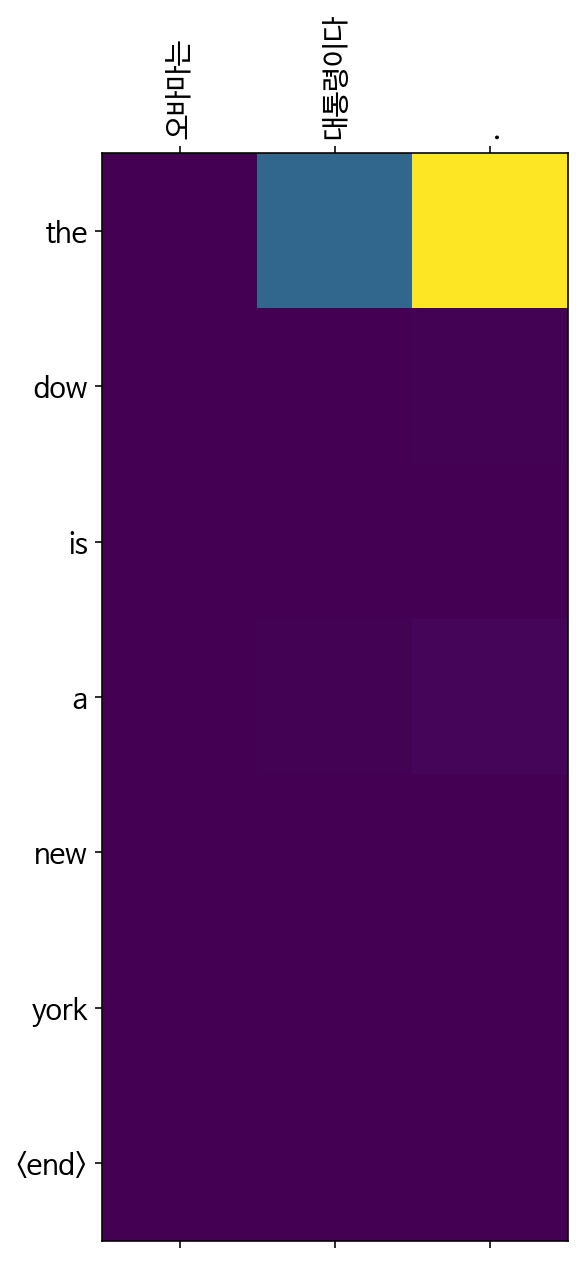

In [100]:
translate("오바마는 대통령이다.", encoder, decoder)

Input: 시민들은 도시 속에 산다 .
Predicted translation: it s . <end> 


/tmp/ipykernel_31/2404480244.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_31/2404480244.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


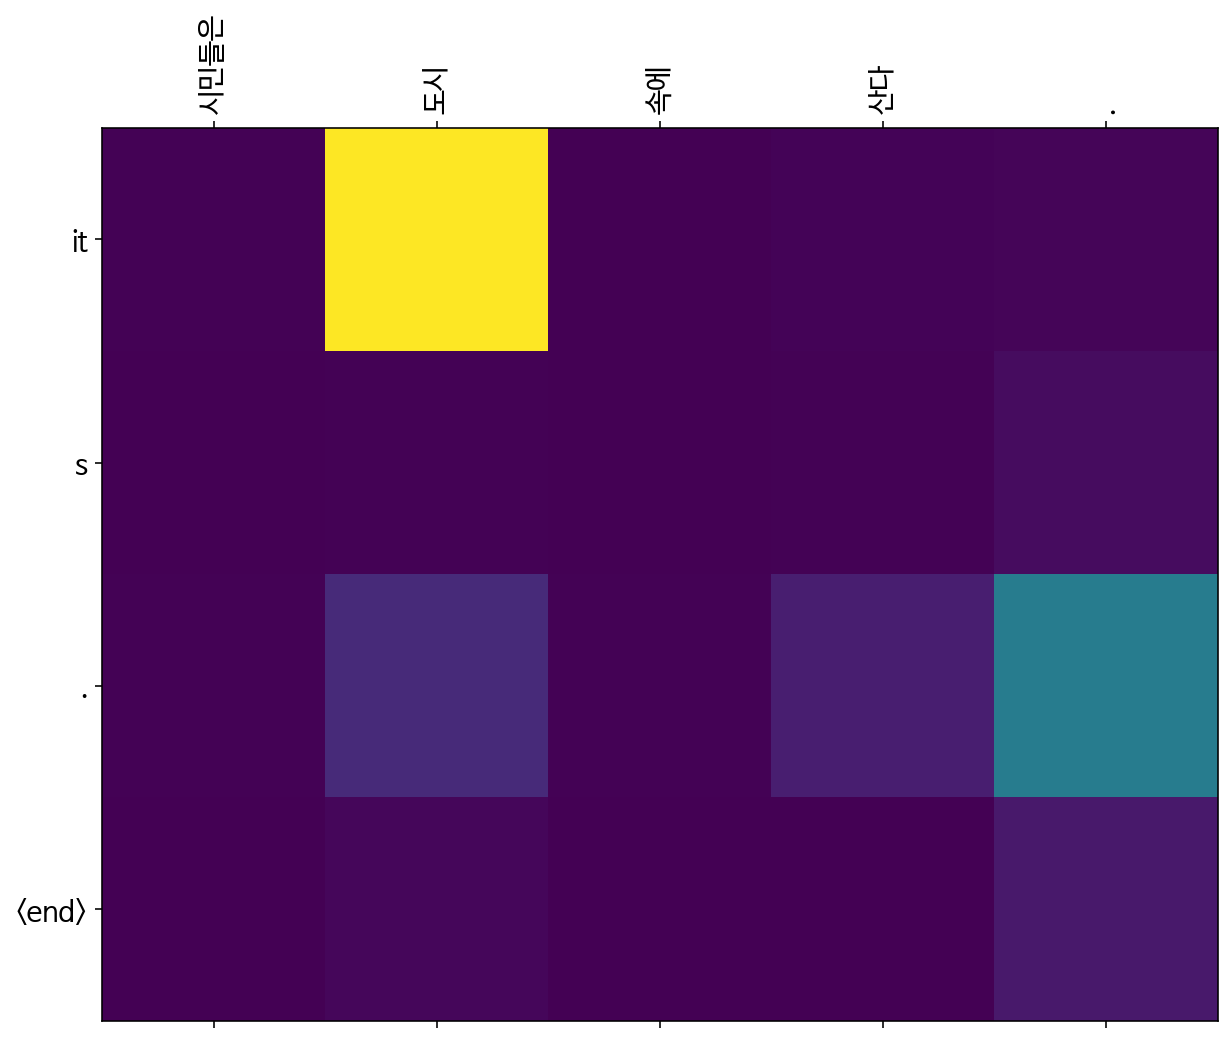

In [101]:
translate("시민들은 도시 속에 산다.", encoder, decoder)

Input: 커피는 필요 없다 .
Predicted translation: the president , the world . <end> 


/tmp/ipykernel_31/2404480244.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_31/2404480244.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


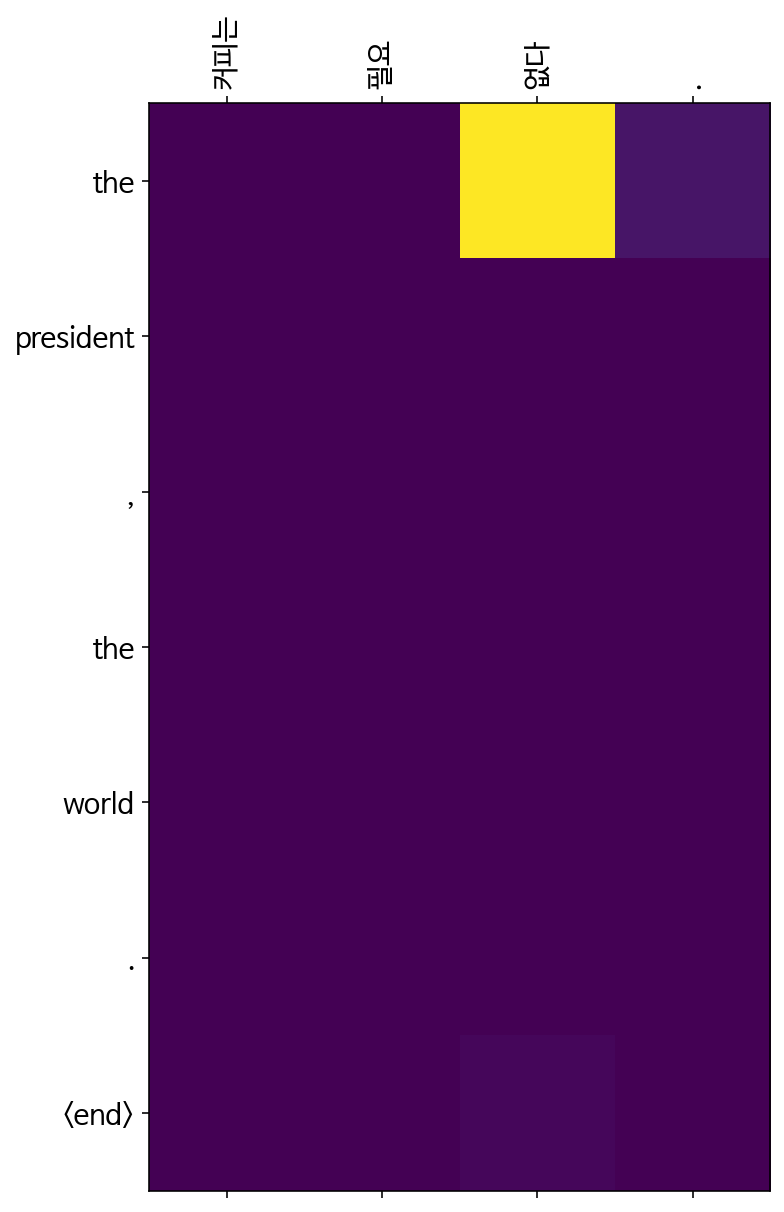

In [102]:
translate("커피는 필요 없다.", encoder, decoder)

Input: 일곱 명의 사상자가 발생했다 .
Predicted translation: the two people were killed in the first time . <end> 


/tmp/ipykernel_31/2404480244.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_31/2404480244.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


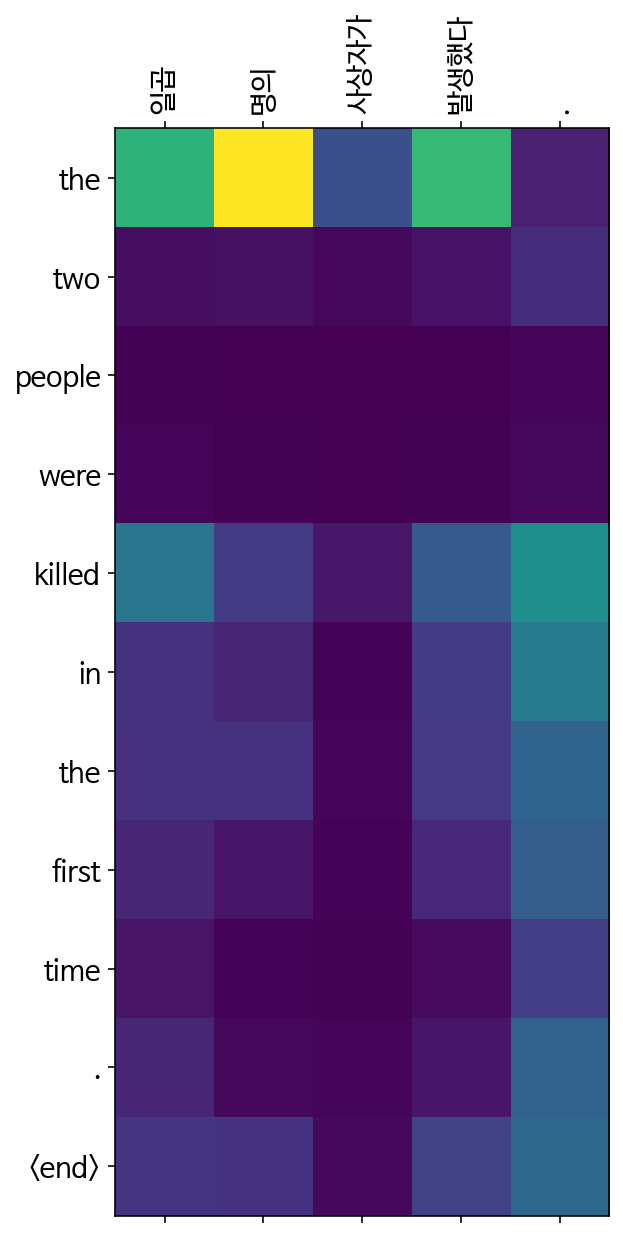

In [104]:
translate("일곱 명의 사상자가 발생했다.", encoder, decoder)

# 회고
### 실습 노드와 달랐던 부분
- 한국어 데이터 정제(정규식,Mecab사용)  
- 한국어와 영어 나눠서 토큰화  
- 기존 모델에 Dropout 모듈 추가
- 훈련 데이터와 검증 데이터 따로 나누지 않음.
- eval_step() 없음.  
  
### 느낀점  
- 언어에 따라 데이터 정제를 다르게 하는 부분이 어려웠다.  
- 생각한 것보다 결과가 더 안좋게 나왔다.  
- 원본 데이터 파일에 짝지어져 있는 한국어-영어 문장을 비교했을 때도 두 문장이 완벽한 의미를 이루고 있지는 않았다. 원본 데이터의 퀄리티 영향도 클 것으로 생각한다.